In [212]:
library(gdata)
library(ggplot2)

In [221]:
GBD <- read.table("../Data/DALY_YLL_deaths_per_region_and_27_diseases_2005.txt")
RCT <- read.table("../Data/RCTs_and_Patients_Nb_local_prop_median_UI_per_region_and_disease.txt")

In [222]:
GBD <- GBD[order(GBD$Region,GBD$Disease),]
RCT <- RCT[order(RCT$Region,RCT$Disease),]

In [223]:
#Disease labels for plot
GBD$Dis_lab <- GBD$Disease
levels(GBD$Dis_lab) <- c("",
               "Cardiovasc.\nand\ncirculatory",
               "Chronic\nrespiratory",
               "Cirrhosis",
               "Congenital\nanomalies",
               "Diabetes\nurinary\nmale infertility",
               "Common infections\n(Diarrhea, meningitis)",
               "Digestive",
               "Gynecol.",
               "Hemoglob. and\nhemolytic anemia",
               "Hepatitis",
               "HIV",
               "Leprosy",
               "Malaria",
               "Maternal",
               "Mental\nand\nbehavioral",
               "Musculosk.",
               "Neglected trop.",
               "Neonatal",
               "Neoplasms",
               "Neurological",
               "Nutritional",
               "Oral",
               "Sense organ",
               "STD",
               "Skin and\nsubcutaneous",
               "Sudden infant death",
               "Tuberculosis")

In [242]:
RCT$Dis_lab <- RCT$Disease
levels(RCT$Dis_lab) <- c("",
                        unique(as.character(GBD$Dis_lab))[
    levels(droplevels(GBD$Disease[GBD$Dis_lab!=""]))%in%levels(RCT$Disease)])

In [282]:
regs <- levels(GBD$Region)
regs <- regs[regs!="All"]

L <- list()

In [287]:

for(i in 1:length(regs)){

    r <- regs[i]
    #All burden in region r
    burd_tot <- GBD$burden[GBD$metr=="daly" & GBD$Region==r & GBD$Disease=="all"]
    #All research
    res_tot <- RCT[RCT$Region==r & RCT$Dis=="All",]   

    #Local burden across diseases
    dfb <- GBD[GBD$metr=="daly" & GBD$Region==r & GBD$Disease!="all",]
    dfb$prop <- 100*dfb$burden/burd_tot
    dfb$mes <- "burden"
    dfb <- dfb[,c("Disease","prop","mes","Dis_lab")] 

    #Local research across diseases
    dfr <- RCT[RCT$Region==r & RCT$Disease!="All",]
    dfr$prop <- dfr$Prop_RCTs_med
    dfr$mes <- "research"
    dfr <- dfr[,c("Disease","prop","mes","Dis_lab")]
    dt <- rbind(dfb,dfr)    

    #Uncertainty intervals for local research
    dfre <- RCT[RCT$Region==r & RCT$Disease!="All",]
    dfre$prop_low <- dfre$Prop_RCTs_low
    dfre$prop_up <- dfre$Prop_RCTs_up
    dfre$mes <- "research"
    dfre <- dfre[,c("Disease","prop_low","prop_up","mes")]    
    
    #10 Principales maladies
    diss <- dfb$Disease[order(dfb$prop,decreasing=TRUE)][1:10]
    dt <- droplevels(dt[dt$Disease%in%diss,])
    dfre <- droplevels(dfre[dfre$Disease%in%diss,])
    #Order of diseases
    dt$Disease <- reorder(dt$Disease,new.order=as.character(diss))
    dfre$Disease <- reorder(dfre$Disease,new.order=as.character(diss))
    
    #Highlighting GAPS
    dt$gap <- dt$Disease
    levels(dt$gap) <- unlist(lapply(levels(dt$Disease),
                                    function(x){
                                        ifelse(sum(dfre$Disease==x)==0,NA,
                                        dt$prop[dt$mes=="burden" & dt$Disease==x]/
                                        dfre$prop_up[dfre$Disease==x])}))
    dt$gap_col <- dt$mes
    dt$gap_col[as.numeric(as.character(dt$gap))>=2 & dt$gap_col=="burden"] <- "burden_gap"
    
    dlbl <- dt[order(dt$Disease),]
    dlbl <- dlbl[dlbl$mes=="burden",]
    dlbl$gap_text <- "plain"
    dlbl$gap_text[dlbl$gap_col=="burden_gap"] <- "bold"

    #GGPLOT Object
    p <- ggplot(dt,aes(Disease))
    p <- p + geom_bar(aes(fill=gap_col,y=prop),position="dodge",stat="identity",width=0.8)
    p <- p + geom_segment(aes(x=as.numeric(Disease)-0.4,xend=as.numeric(Disease)+0.4,y=prop/2,yend=prop/2,size=5),linetype="dashed",data=dt[dt$mes=="burden",],lwd=0.1)
    p <- p + geom_errorbar(aes(x=as.numeric(Disease)+0.2,ymax=prop_up,ymin=prop_low),width=0.2,data=dfre)
    p <- p + scale_fill_manual(values = c("burden"="orange","burden_gap"="red","research"="blue"))

    p <- p + scale_x_discrete(label = dlbl$Dis_lab,
                              name=paste("10 Groups of diseases causing highest burden in",r,sep="\n"))
    p <- p + scale_y_continuous(name=paste("Local proportion (%) of burden and research in",r,sep="\n"),
                                limits = c(0,40))
    
    p <- p + theme(axis.text.x = element_text(
        face=dlbl$gap_text,
        angle=55,
        hjust=0.5,
        vjust=0.8)) +
     theme(panel.background = element_blank()) + 
     theme(panel.grid.major.y = element_line(colour = "grey",size=0.1)) +
     theme(panel.grid.major.x = element_blank()) + 
     theme(axis.ticks.x=element_blank()) + 
     theme(legend.position = "none")

    L[[i]] <- p
}

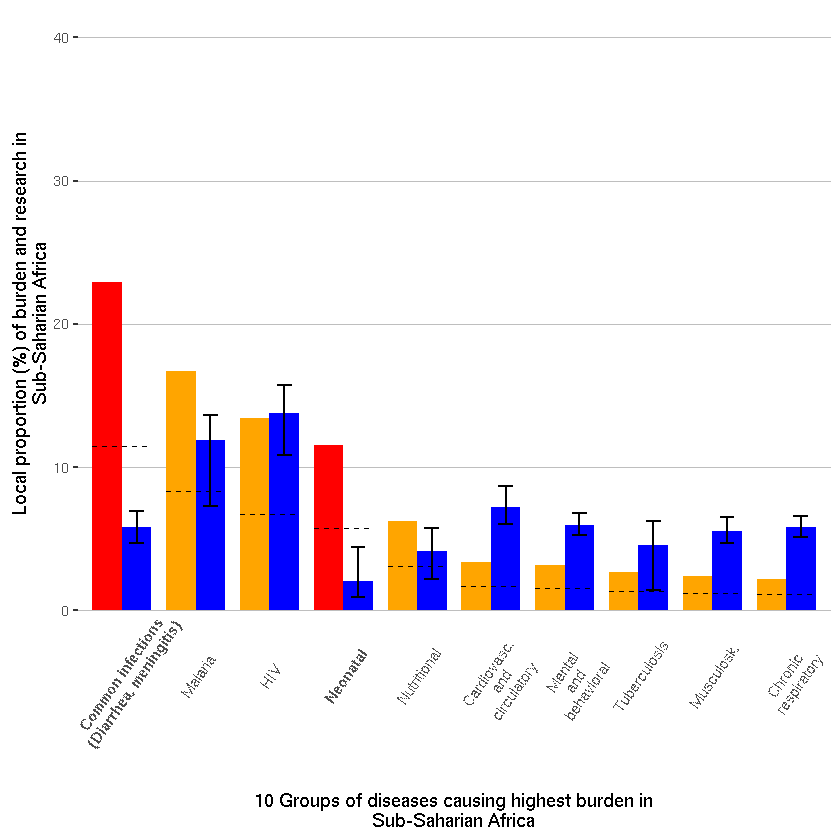

In [294]:
L[[7]]

In [295]:
multiplot(L[[1]], L[[2]], L[[3]], L[[4]], cols=2)

ERROR: Error in eval(expr, envir, enclos): could not find function "multiplot"


In [296]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  require(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
        
    }
  }
}

In [298]:
library(grid)

<environment: R_GlobalEnv>
$x
[1] "Disease"

$y
[1] "prop"

$fill
[1] "gap_col"

$xend
[1] "as.numeric(Disease) + 0.4"

$yend
[1] "prop/2"

$size
[1] "5"

$ymax
[1] "prop_up"

$ymin
[1] "prop_low"

                                                                                     Disease
28                                                   Cardiovascular and circulatory diseases
29                                                              Chronic respiratory diseases
32                                           Diabetes, urinary diseases and male infertility
33  Diarrhea, lower respiratory infections, meningitis, and other common infectious diseases
42                                                           Mental and behavioral disorders
43                                                                 Musculoskeletal disorders
46                                                                                 Neoplasms
47                                                        

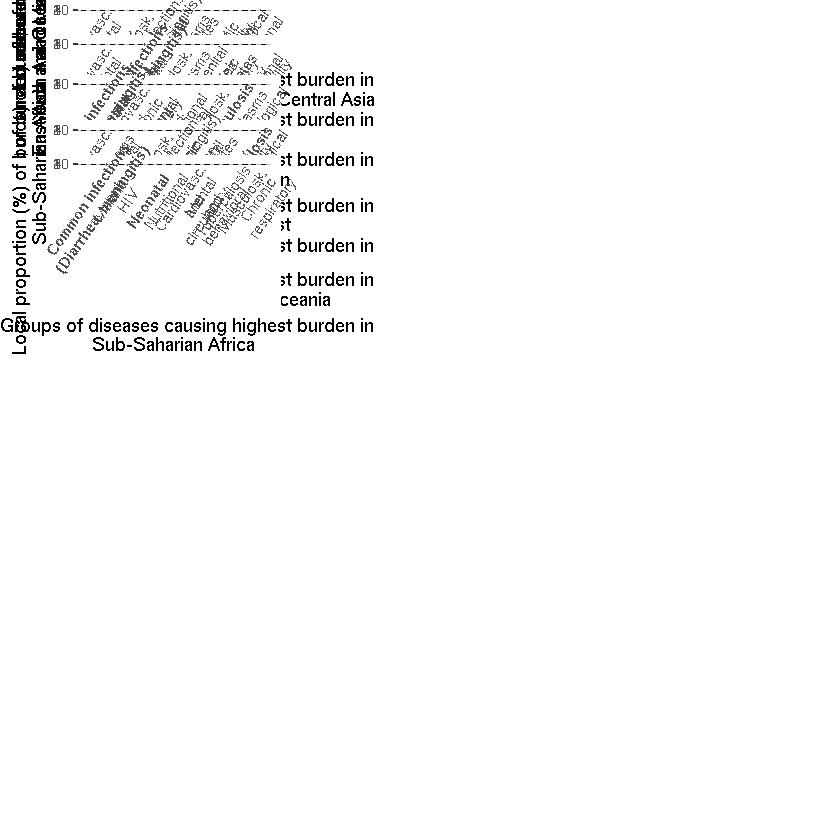

In [299]:
multiplot(plotlist = L,cols = 3)